# Building a Flask app on Image Classification of Dog/Cat Dataset implemented by Convolutional Neural Network (CNN)

### Dataset
Dogs vs. Cats [dataset](https://www.kaggle.com/c/dogs-vs-cats/data) contains 25,000 images of dogs and cats with the labels 
* 1 = dog
* 0 = cat 

### Project goals
- Building a deep neural network using TensorFlow to classify dogs and cats images (This Jupyter Notebook is dedicated for the building model part). 

- Making a Flask application so user can upload their photos and receive the prediction.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

Network Parameter:
* Rectifier Linear Unit 
* Adam optimizer
* Sigmoid on Final output
* Binary CrossEntropy loss

In [3]:
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

## Data Augmentation
Using some Data Augmentation techniques for more data and Better results.
* Shearing of images
* Random zoom
* Horizontal flips

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

#Training Set
train_set = train_datagen.flow_from_directory('train',
                                             target_size=(64,64),
                                             batch_size=32,
                                             class_mode='binary')
#Validation Set
test_set = test_datagen.flow_from_directory('test',
                                           target_size=(64,64),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)
#Test Set /no output available
test_set1 = test_datagen.flow_from_directory('test1',
                                            target_size=(64,64),
                                            batch_size=32,
                                            shuffle=False)



Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
classifier.fit_generator(train_set,
                        steps_per_epoch=800, 
                        epochs = 200,
                        validation_data = test_set,
                        validation_steps = 20, 
                        );

classifier.save('dogcat_model.h5')

In [6]:
from tensorflow.keras.models import load_model
classifier = load_model('dogcat_model.h5')

### Prediction of Single Image

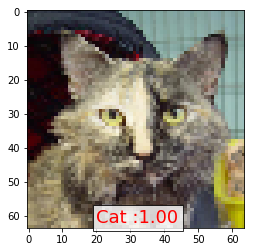

In [7]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('test/Cat/10.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='Dog :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='Cat :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()


In [8]:
import pandas as pd
test_set.reset
ytesthat = classifier.predict_generator(test_set)
df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})

In [9]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

,filename,predict,y,y_pred
0,Cat/0.jpg,0.00000,0,0
1,Cat/1.jpg,0.00000,0,0
2,Cat/10.jpg,0.00000,0,0
3,Cat/100.jpg,0.99970,0,1
4,Cat/10001.jpg,0.00000,0,0
5,Cat/10009.jpg,0.02340,0,0
6,Cat/1001.jpg,0.00001,0,0
7,Cat/10012.jpg,0.00000,0,0
8,Cat/10017.jpg,0.00000,0,0
9,Cat/10018.jpg,0.00000,0,0


In [10]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 122


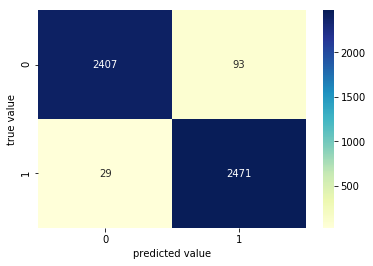

In [11]:
#Prediction of test set
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [14]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total para

### Model Performance on Unseen Data

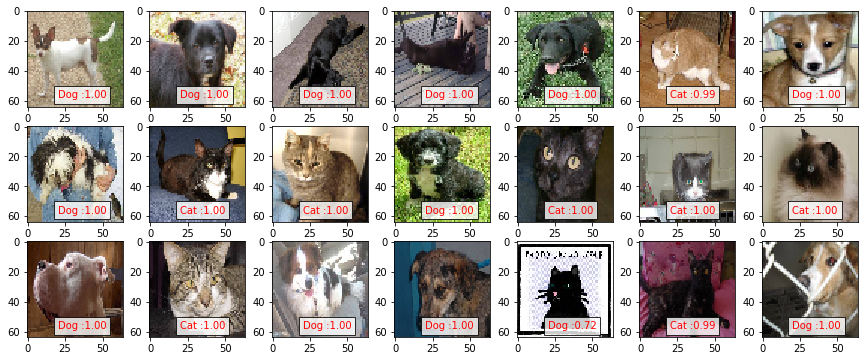

In [22]:
# for generator image set u can use 
# ypred = classifier.predict_generator(test_set)

fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img('test1/'+test_set1.filenames[np.random.choice(range(12500))], target_size=(64, 64))
    img = image.img_to_array(img1)
    img = img/255
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
        value ='Dog :%1.2f'%(prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    else:
        value ='Cat :%1.2f'%(1.0-prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1)


In [23]:
%%capture
# Model Accuracy
x1 = classifier.evaluate_generator(train_set)
x2 = classifier.evaluate_generator(test_set)

In [24]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

Training Accuracy  : 99.96%     Training loss  : 0.002454
Validation Accuracy: 97.56%     Validation loss: 0.102678


### Conclusion
The Architecture and parameter used in this network are capable of producing accuracy of **97.56%** on Validation Data which is pretty good. It is possible to Achieve more accuracy on this dataset using deeper network and fine tuning of network parameters for training.